In [8]:
import os
import numpy as np
import pandas as pd

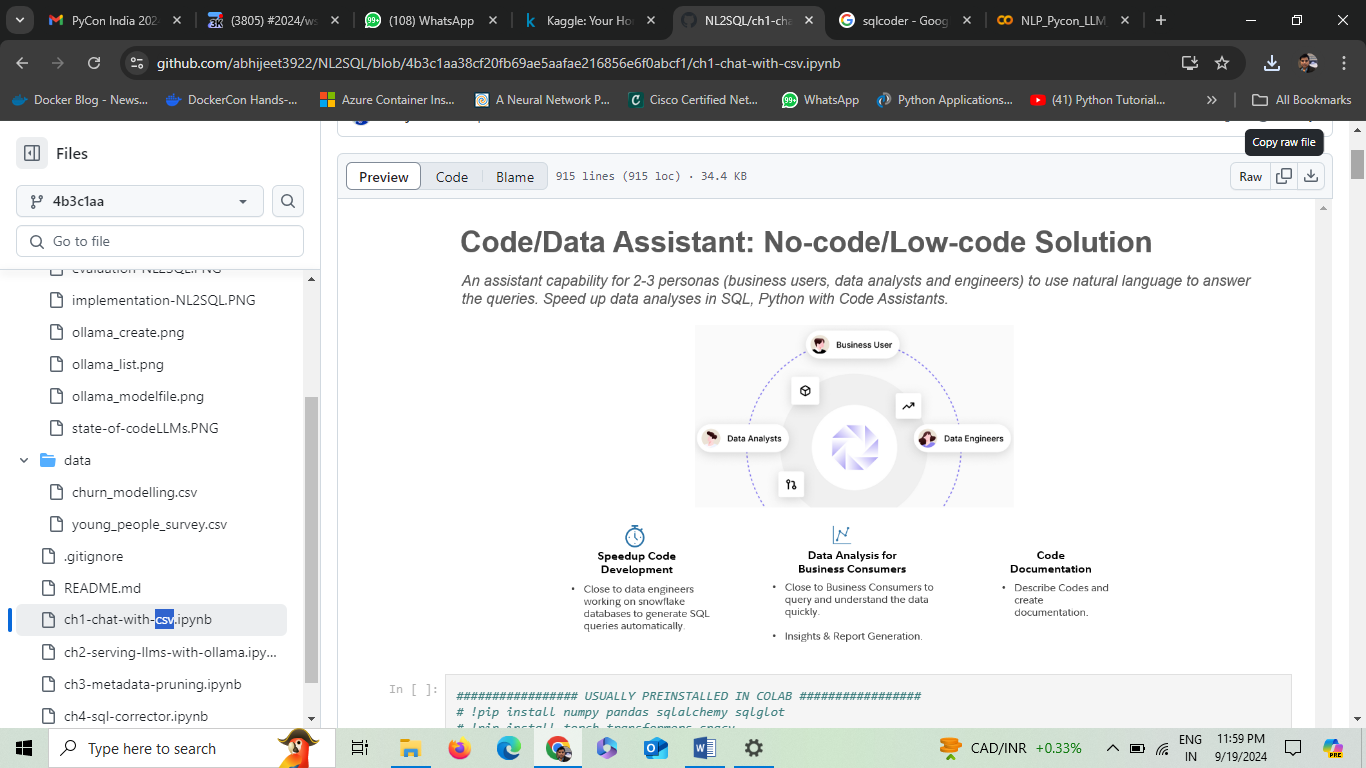

################# USUALLY PREINSTALLED IN COLAB #################
# !pip install numpy pandas sqlalchemy sqlglot
# !pip install torch transformers spacy

!pip install Levenshtein
!pip install accelerate
!pip install bitsandbytes
!pip install sentence-transformers
!pip install spacy-transformers

!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_trf

Get CSV data from Kaggle
We are using the Young People Survey Dataset from Kaggle. The primary reason for choosing this dataset is because it has a pretty large number of columns.

In [10]:
df = pd.read_csv('/content/sample_data/young_people_survey.csv')
df.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


Load data into SQLite DB
For a demonstration of real-world usecases, we will load our CSV data into a database. Once done, we will extract the DDL or the Database Definition Language, i.e. the commands which actually define our table, or more accurately, our table schema.

We will use sqlite for this usecase but you can use your DB of choice. You will need to of course install any relevant libraries to communicate with your DB using python. For simplicity's sake, we use built-in functions of Pandas to load and read data from the database. Of course, you can use your DB connector as well to peform these operations.

In [11]:
from sqlalchemy import create_engine
engine = create_engine(f"sqlite:///mysqlitedb.db")
table_name = 'young_people_survey'

try:
    df = pd.read_csv('/content/sample_data/young_people_survey.csv')
    df.to_sql(table_name, engine, index=False)
    print('Data loaded from CSV file!')
except ValueError as e:
    err_msg = e.args[0]
    if 'already exists' in err_msg:
        print('Table already exists in SQLite DB')

Data loaded from CSV file!


sqlite databases contain a table known as sqlite_master which contains the details of all tables hosted by the database. This table contains the "derived" DDL for each table. If you are using any other database, the process for getting the DDL for your table might be different.

In [12]:
with engine.connect() as conn, conn.begin():
    sqlite_master = pd.read_sql_query("SELECT * FROM sqlite_master", conn)
sqlite_master['sql_fmt'] = sqlite_master['sql'].apply(lambda z: [x.strip().strip(',').rsplit(' ', maxsplit=1) for x in z.split('\n')[1:-1]])

table_desc_dict = {}
for _, row in sqlite_master.iterrows():
    table_desc_dict[row['name']] = row['sql']

schema = table_desc_dict[table_name]
print(schema)

CREATE TABLE young_people_survey (
	"Music" FLOAT, 
	"Slow songs or fast songs" FLOAT, 
	"Dance" FLOAT, 
	"Folk" FLOAT, 
	"Country" FLOAT, 
	"Classical music" FLOAT, 
	"Musical" FLOAT, 
	"Pop" FLOAT, 
	"Rock" FLOAT, 
	"Metal or Hardrock" FLOAT, 
	"Punk" FLOAT, 
	"Hiphop, Rap" FLOAT, 
	"Reggae, Ska" FLOAT, 
	"Swing, Jazz" FLOAT, 
	"Rock n roll" FLOAT, 
	"Alternative" FLOAT, 
	"Latino" FLOAT, 
	"Techno, Trance" FLOAT, 
	"Opera" FLOAT, 
	"Movies" FLOAT, 
	"Horror" FLOAT, 
	"Thriller" FLOAT, 
	"Comedy" FLOAT, 
	"Romantic" FLOAT, 
	"Sci-fi" FLOAT, 
	"War" FLOAT, 
	"Fantasy/Fairy tales" FLOAT, 
	"Animated" FLOAT, 
	"Documentary" FLOAT, 
	"Western" FLOAT, 
	"Action" FLOAT, 
	"History" FLOAT, 
	"Psychology" FLOAT, 
	"Politics" FLOAT, 
	"Mathematics" FLOAT, 
	"Physics" FLOAT, 
	"Internet" FLOAT, 
	"PC" FLOAT, 
	"Economy Management" FLOAT, 
	"Biology" FLOAT, 
	"Chemistry" FLOAT, 
	"Reading" FLOAT, 
	"Geography" FLOAT, 
	"Foreign languages" FLOAT, 
	"Medicine" FLOAT, 
	"Law" FLOAT, 
	"Cars" FLOAT

Prompt LLM to generate SQL
You can use your LLM of choice to generate SQL commands, but models specifically fine-tuned to generate high-quality SQL are obviously prefered. We will use the model sqlcoder-7b-2 by Defog, which was derived by finetunig the llama-2 model released by Meta.

While we will be prompting the model as described by the model's creators, feel free to experiment with other models and other prompt templates. Other popular LLMs for code generation are Deepseek-Coder-V2 by DeepSeek (深度求索) and CodeQwen1.5-7B-Chat by Qwen

#####SQLgen BenchmarksBIRD-SQL
BIRD (BIg Bench for LaRge-scale Database Grounded Text-to-SQL Evaluation) represents a pioneering, cross-domain dataset that examines the impact of extensive database contents on text-to-SQL parsing. BIRD contains over 12,751 unique question-answer pairs, 95 big databases with a total size of 33.4 GB. It also covers more than 37 professional domains, such as blockchain, hockey, healthcare and education, etc.

###Spider 1.0
Spider 1.0 is a large-scale comlpex and cross-domain semantic parsing and text-to-SQL dataset annotated by 11 Yale students. The goal of the Spider challenge is to develop natural language interfaces to cross-domain databases. It consists of 10,181 questions and 5,693 unique complex SQL queries on 200 databases with multiple tables covering 138 different domains.

###LLM Benchmarks
HumanEval
HumanEval problem solving dataset is introduced in the paper "Evaluating Large Language Models Trained on Code". It used to measure functional correctness for synthesizing programs from docstrings. It consists of 164 original programming problems, assessing language comprehension, algorithms, and simple mathematics, with some comparable to simple software interview questions.

EvalPlus
EvalPlus is a rigorous evaluation framework for LLM4Code, with:
✨ HumanEval+: 80x more tests than the original HumanEval!
✨ MBPP+: 35x more tests than the original MBPP!
[...]
Why EvalPlus? What does using EvalPlus datasets bring to you?
✨ Reliable ranking: See our leaderboard for the latest LLM ranking before and after rigorous evaluation.
✨ Code robustness: Look at the score differences! esp. before (e.g., HumanEval) and after (e.g., HumanEval+) using EvalPlus! The drop/gap indicates if the LLM can generate more robust code: less drop means more robustness and a larger drop means the code tends to be more fragile.

InfiCoder-eval
InfiCoder-eval is a large-scale free-form question-answering (QA) benchmark for code. InfiCoder-Eval comprises 270 carefully picked high-quality StackOverflow questions, covering 18 programming languages. [...] As confirmed with human experiments, InfiCoder-Eval evaluation aligns with humans better than model-based evaluation and runs much faster at the same time. [...] Existing benchmarks weigh heavily on code generation, unit-test-based evaluation, and a limited set of programming languages. InfiCoder-Eval processes a much higher diversity to reflect real-world code LLMs’ usage scenarios and is far from saturation.

LMSYS Chatbot Arena Leaderboard
LMSYS Chatbot Arena is a crowdsourced open platform for LLM evals. We've collected over 200,000 human preference votes to rank LLMs with the Elo ranking system.

Big Code Models Leaderboard
Big Code Models Leaderboard (open source models only) compares performance of base multilingual code generation models on HumanEval benchmark and MultiPL-E. We also measure throughput and provide information about the models. We only compare open pre-trained multilingual code models, that people can start from as base models for their trainings. Win Rate represents how often a model outperforms other models in each language, averaged across all languages. The scores of instruction-tuned models might be significantly higher on humaneval-python than other languages. [...] HumanEval-Python reports the pass@1 on HumanEval; the rest is from MultiPL-E benchmark. For all languages, we use the original benchamrk prompts for all models except HumanEval-Python, where we separate base from instruction models.

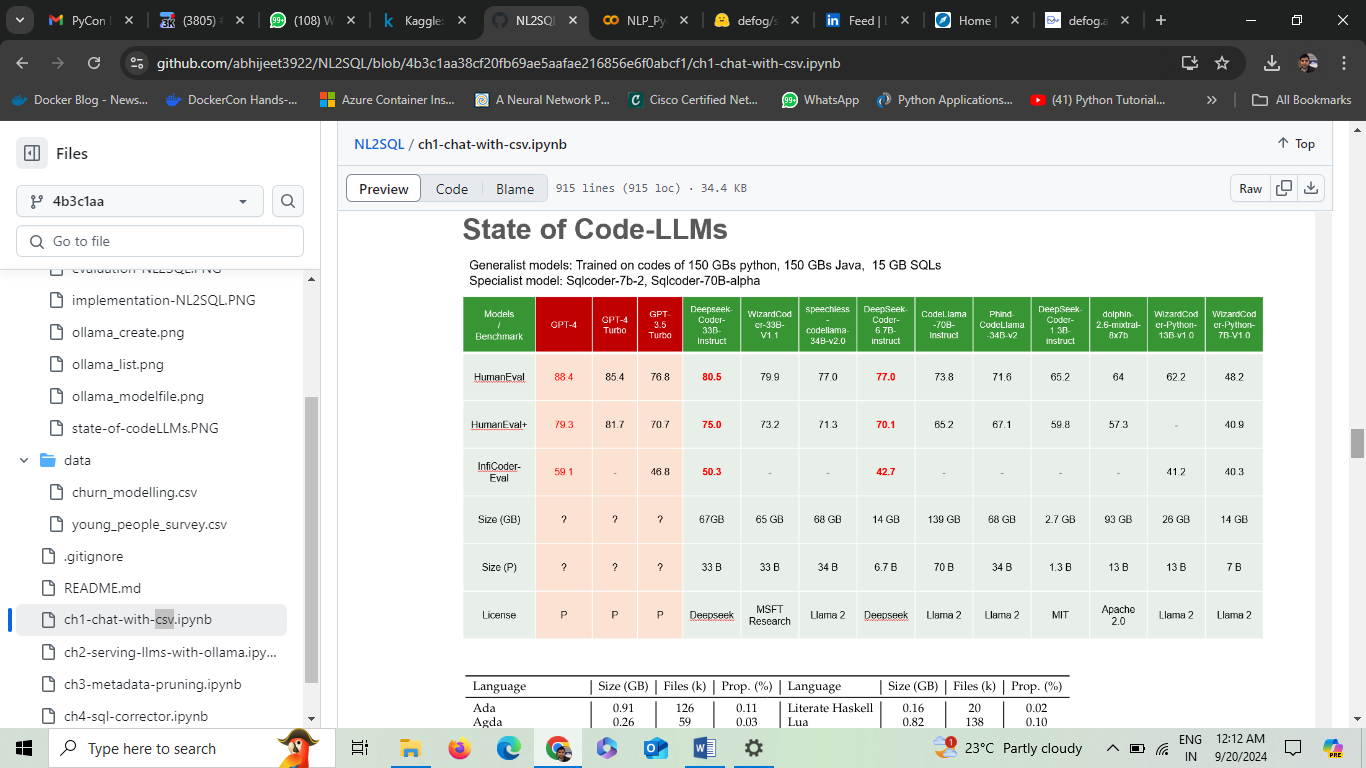

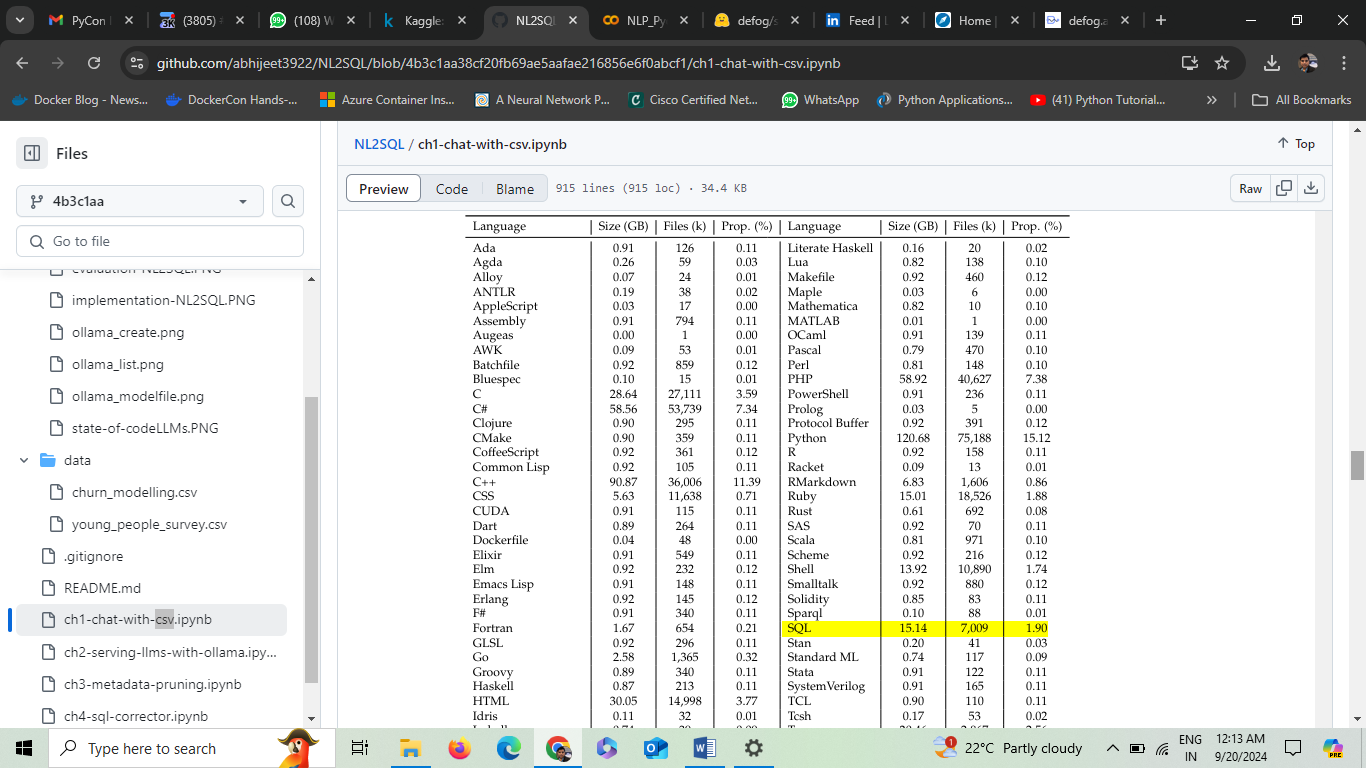

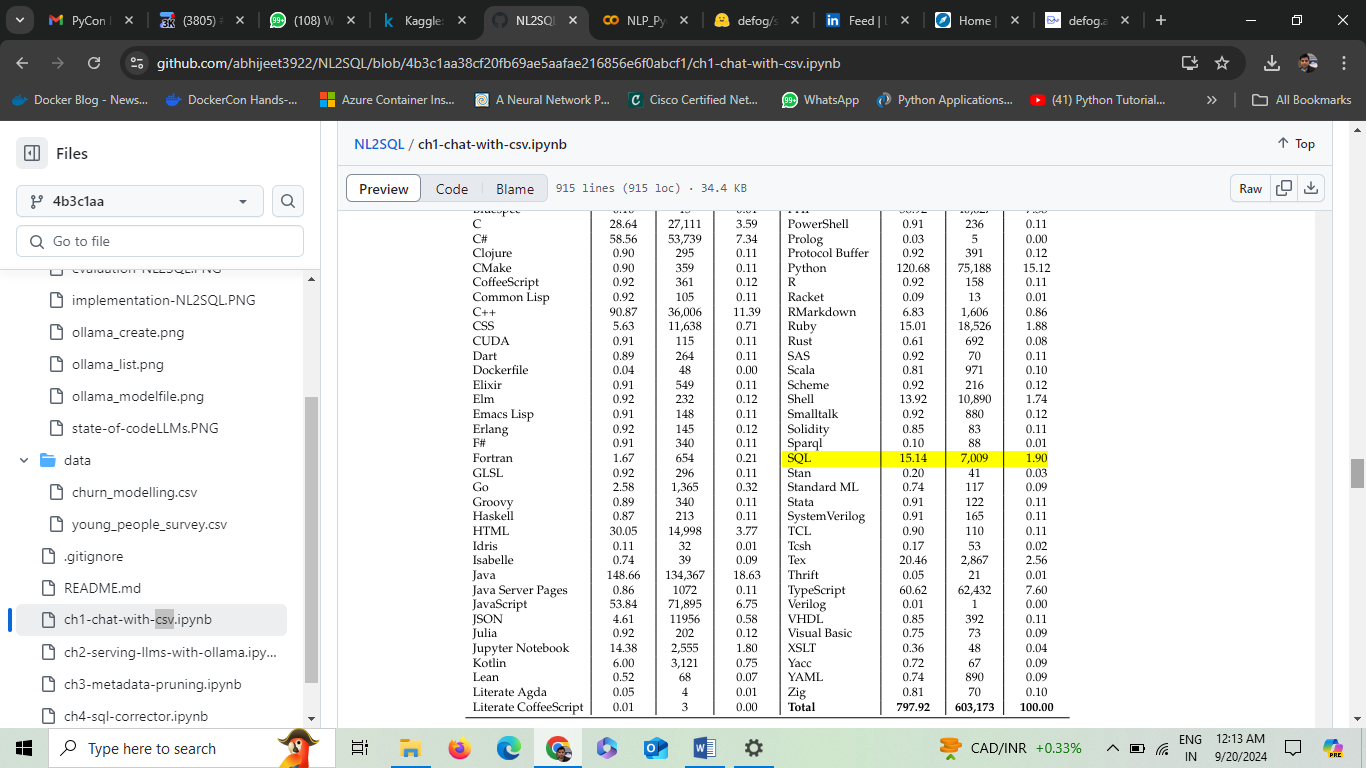

In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/cloud-user/data/miniconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The following code downloads the SQLCoder 7B model to your environment. The model weights total 13.6 GB so depending on your internet connection it might take a while.

If you have less than 16 GB of GPU RAM, you can choose to enable the load_in_8bit=True line and comment out torch_dtype=torch.float16. This will however increase the time it takes for the model to load.

In [14]:
!pip install -U bitsandbytes

In [15]:
model_name = "defog/sqlcoder-7b-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype=torch.float16, # Disable if enabling the below line
    #load_in_8bit=True, # Disable if enabling the above line
    device_map="auto",
    use_cache=True,
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

model_name = "defog/sqlcoder-7b-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    # torch_dtype=torch.float16, # Disable if enabling the below line
    load_in_8bit=True, # Disable if enabling the above line
    device_map="auto",
    use_cache=True,
)

Downloading shards: 100%|██████████| 3/3 [04:04<00:00, 81.54s/it]
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

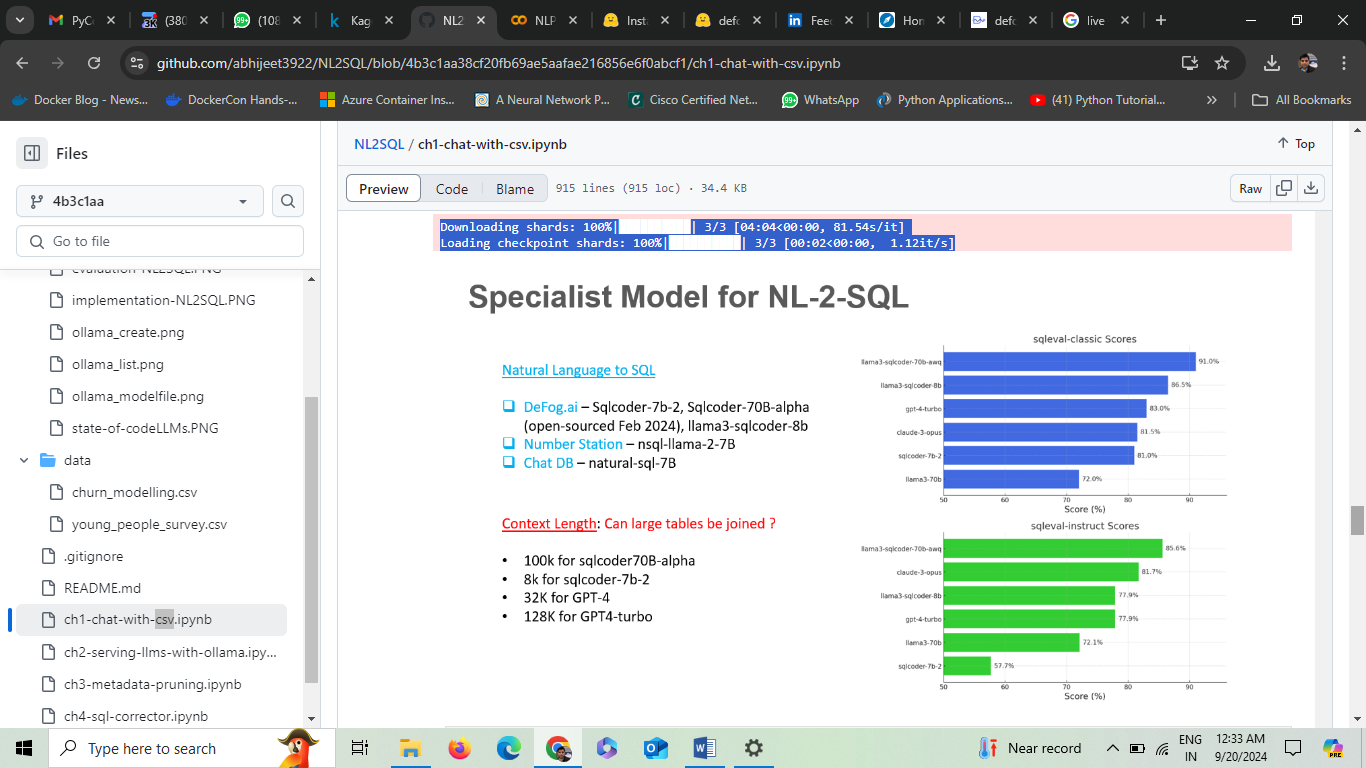

In [16]:
def generate_query(prompt, device='cpu'):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generated_ids = model.generate(
        **inputs,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=400,
        do_sample=False,
        num_beams=1,
    )
    outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    if device == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        # empty cache so that you do generate more results w/o memory crashing
        # particularly important on Colab – memory management is much more straightforward
        # when running on an inference service
    return outputs[0].split("[SQL]")[-1]

Finetuned LLMs are very sensitive to the prompt. Make sure you are using the prompt format specified by the creators of the model. You can usually get this information in the HuggingFace model card or in Github repos.

In [17]:
question = 'Which are the rows which have more than 4 for at Horror and Thriller movies ?'

prompt_template = """### Task
Generate a SQL query to answer [QUESTION]{question}[/QUESTION]

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'

## Database Schema
This query will run on a database whose schema is represented in this string: {db_schema}

### Answer
Given the database schema, here is the SQL query that answers [QUESTION]{question}[/QUESTION] [SQL]
"""

prompt = prompt_template.format(question=question, db_schema=schema)
print(prompt)

### Task
Generate a SQL query to answer [QUESTION]Which are the rows which have more than 4 for at Horror and Thriller movies ?[/QUESTION] 

### Instructions
- If you cannot answer the question with the available database schema, return 'I do not know'

## Database Schema 
This query will run on a database whose schema is represented in this string: CREATE TABLE young_people_survey (
	"Music" FLOAT, 
	"Slow songs or fast songs" FLOAT, 
	"Dance" FLOAT, 
	"Folk" FLOAT, 
	"Country" FLOAT, 
	"Classical music" FLOAT, 
	"Musical" FLOAT, 
	"Pop" FLOAT, 
	"Rock" FLOAT, 
	"Metal or Hardrock" FLOAT, 
	"Punk" FLOAT, 
	"Hiphop, Rap" FLOAT, 
	"Reggae, Ska" FLOAT, 
	"Swing, Jazz" FLOAT, 
	"Rock n roll" FLOAT, 
	"Alternative" FLOAT, 
	"Latino" FLOAT, 
	"Techno, Trance" FLOAT, 
	"Opera" FLOAT, 
	"Movies" FLOAT, 
	"Horror" FLOAT, 
	"Thriller" FLOAT, 
	"Comedy" FLOAT, 
	"Romantic" FLOAT, 
	"Sci-fi" FLOAT, 
	"War" FLOAT, 
	"Fantasy/Fairy tales" FLOAT, 
	"Animated" FLOAT, 
	"Documentary" FLOAT, 
	"Western

In [18]:
generated_sql = generate_query(prompt, device='cuda')
print(f'SQL generated by the model: {generated_sql}')

SQL generated by the model: 
 SELECT * FROM young_people_survey WHERE "Horror" > 4 AND "Thriller" > 4


Finally we execute the generated SQL query on our DB and verify its performance.

In [19]:
engine = create_engine(f"sqlite:///mysqlitedb.db")

with engine.connect() as conn, conn.begin():
    query_result = pd.read_sql_query(generated_sql, conn)

query_result

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,3.0,2.0,3.0,3.0,2.0,5.0,5.0,...,20.0,186.0,77.0,1.0,male,right handed,secondary school,no,city,block of flats
1,1.0,3.0,2.0,2.0,3.0,4.0,3.0,3.0,5.0,5.0,...,18.0,177.0,77.0,0.0,male,right handed,secondary school,yes,city,block of flats
2,5.0,3.0,3.0,2.0,3.0,4.0,3.0,2.0,5.0,5.0,...,20.0,186.0,77.0,1.0,male,right handed,secondary school,no,city,block of flats
3,5.0,5.0,1.0,1.0,3.0,2.0,2.0,2.0,5.0,5.0,...,24.0,186.0,85.0,1.0,male,left handed,secondary school,no,city,block of flats
4,5.0,5.0,3.0,1.0,3.0,2.0,3.0,3.0,4.0,3.0,...,20.0,158.0,46.0,4.0,female,left handed,secondary school,no,city,block of flats
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,4.0,4.0,4.0,3.0,3.0,5.0,1.0,5.0,4.0,1.0,...,23.0,185.0,92.0,0.0,male,left handed,secondary school,yes,city,block of flats
90,5.0,5.0,5.0,3.0,3.0,3.0,5.0,5.0,5.0,2.0,...,17.0,170.0,65.0,2.0,female,right handed,primary school,no,city,block of flats
91,5.0,4.0,1.0,2.0,4.0,5.0,5.0,3.0,4.0,1.0,...,19.0,168.0,57.0,1.0,female,left handed,secondary school,no,village,house/bungalow
92,5.0,3.0,3.0,3.0,2.0,3.0,3.0,4.0,3.0,1.0,...,16.0,153.0,62.0,1.0,female,right handed,primary school,no,city,block of flats
